<h2>INSTALLAZIONE LIBRERIE</h2>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Installazione librerie <strong>necessarie per il funzionamento</strong> del progetto:
</p>

In [1]:
pip install --quiet scipy matplotlib seaborn wordcloud nltk scikit-learn plotly nbformat

Note: you may need to restart the kernel to use updated packages.


<h2>INTRODUZIONE</h2>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Il problema principale riguarda l'interpretazione delle <strong>mutazioni genetiche</strong> nei <strong>tumori</strong>. Quando si sequenzia il <strong>DNA</strong> di un tumore, emergono migliaia di mutazioni. Tuttavia, non tutte sono rilevanti per la <strong>crescita del tumore</strong>. Alcune mutazioni, chiamate "<strong>driver</strong>", favoriscono la proliferazione delle <strong>cellule tumorali</strong>, mentre altre, chiamate "<strong>passenger</strong>", sono neutre e non influenzano lo sviluppo del tumore. Distinguere tra queste due categorie è fondamentale per sviluppare <strong>terapie personalizzate</strong> ed efficaci.
</p>
<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Attualmente, questo lavoro viene svolto manualmente da <strong>patologi clinici</strong>, che analizzano ogni mutazione sulla base delle informazioni disponibili nella <strong>letteratura scientifica</strong>. Questo processo è estremamente <strong>laborioso</strong> e richiede molto <strong>tempo</strong>, dato che ogni mutazione deve essere valutata attentamente.
</p>
<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Il <strong>Memorial Sloan Kettering Cancer Center (MSKCC)</strong>, uno dei principali <strong>centri oncologici</strong> al mondo, ha costruito un'ampia <strong>base di dati annotata</strong> da esperti in cui migliaia di mutazioni sono state già classificate da <strong>ricercatori</strong> e <strong>oncologi</strong>. L'obiettivo è sviluppare un <strong>sistema automatizzato</strong>, basato su tecnologie di <strong>Machine Learning</strong>, che possa utilizzare questa base di dati per <strong>classificare automaticamente</strong> le nuove mutazioni genetiche. Questo sistema permetterebbe di accelerare il processo di <strong>interpretazione genetica</strong>, riducendo il lavoro manuale e facilitando l'adozione della <strong>medicina di precisione</strong> nel trattamento del <strong>cancro</strong>.
</p>
<br>


<h2>IMPORTAZIONE LIBRERIE</h2>

In [2]:
import numpy as np # libreria per calcolo scientifico
import pandas as pd # libreria per analisi e manipolazione dati
import seaborn as sns # libreria per la creazione di grafici 
import matplotlib.pyplot as plt # libreria per la creazione di grafici 
import string
import nbformat


#Text-Processing
import re #libreria per manipolazioni espressioni regolari
from wordcloud import WordCloud

import nltk #libreria per l'elaborazione del linguaggio (NLP)
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder

from string import punctuation
from collections import Counter


#Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import log_loss

#Visualization 
import plotly.express as px # libreria per la visualizzazione dei dati 
import plotly.offline as py
py.init_notebook_mode(connected=True)

#Models 
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

#Warnings
import warnings # per la gestione degli errori
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt_tab to /Users/diego/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/diego/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/diego/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h2>ESPLORAZIONE DEI DATI (EDA)</h2>

Il set di dati è composto da due file: 

<h3>training_variants:</h3>
<p>Questo file contiene le informazioni strutturate sulle mutazioni genetiche.</p>
<p>Ogni riga rappresenta una singola mutazione ed è composta da quattro campi:</p>
<ul>
    <li><strong>ID</strong>: Un identificativo univoco che collega le informazioni genetiche alle prove cliniche corrispondenti nel file <em>training_text</em>.</li>
    <li><strong>Gene</strong>: Il gene in cui è avvenuta la mutazione.</li>
    <li><strong>Variation</strong>: La variazione amminoacidica associata alla mutazione.</li>
    <li><strong>Class</strong>: La classe (da 1 a 9) in cui la mutazione è stata classificata. Queste classi rappresentano diverse categorie che descrivono la rilevanza clinica della mutazione.</li>
</ul>

<h3>training_text:</h3>
<p>Questo file contiene le prove cliniche sotto forma di testo, utilizzate dagli esperti per classificare le mutazioni.</p>
<p>Ogni riga corrisponde a una mutazione genetica, con due campi:</p>
<ul>
    <li><strong>ID</strong>: Lo stesso identificativo presente nel file <em>training_variants</em>, che permette di collegare una mutazione specifica al testo clinico corrispondente.</li>
    <li><strong>Text</strong>: Il testo che descrive le prove cliniche associate a quella specifica mutazione. Questa parte è fondamentale per l'algoritmo, poiché fornisce informazioni dettagliate che gli esperti hanno utilizzato per la classificazione.</li>
</ul>

<h3>Collegamento tra i file</h3>
<p>I due file sono collegati tramite il campo <strong>ID</strong>. Ad esempio, la mutazione con <strong>ID=15</strong> nel file <em>training_variants</em> corrisponde alla descrizione delle prove cliniche con <strong>ID=15</strong> nel file <em>training_text</em>. In questo modo, l'algoritmo può associare una mutazione genetica specifica con le prove cliniche testuali utilizzate per classificarla.</p>


<strong>Source:</strong> https://www.kaggle.com/c/msk-redefining-cancer-treatment/data

In [3]:
# Caricamento Dataset
training_variants = pd.read_csv("/Users/diego/Desktop/TIROCINIO/DATASET/training_variants.csv")
training_text = pd.read_csv("/Users/diego/Desktop/TIROCINIO/DATASET/training_text.csv", sep="\|\|", engine='python', header=None, skiprows=1, names=['ID','text'])

# Stampa strutturata dei dati
print(f"{'\nDataset':<20}{'(Righe, Colonne)':<30}")
print(f"{'-'*50}")
print(f"{'Training variants':<20}{str(training_variants.shape):<30}")
print(f"{'Training text':<20}{str(training_text.shape):<30}")



Dataset            (Righe, Colonne)              
--------------------------------------------------
Training variants   (3321, 4)                     
Training text       (3321, 2)                     


<br>
<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Da una breve analisi della struttura dei 2 file, si osserva che <strong>entrambi</strong> i file hanno <strong>3321 righe</strong>, il che significa che ci sono <strong>3321 mutazioni genetiche</strong> con <strong>prove cliniche</strong> corrispondenti. Si nota come il <strong>dataset di training</strong> fornisce un numero moderato di esempi per l'<strong>addestramento</strong> del <strong>modello</strong>, rendendo possibile un buon livello di <strong>apprendimento</strong>, ma lasciando aperta la necessità di <strong>tecniche</strong> per gestire il <strong>testo</strong> probabilmente molto <strong>variegato</strong> e ricco di <strong>dettagli tecnici</strong>.
</p><br>


In [4]:
training_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [5]:
training_text.head()

,ID,text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [6]:
#unione varianti e testo di addestramento 
training_tot_noprocess = pd.merge(training_variants, training_text, on = 'ID')
training_tot_noprocess.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [7]:
# Conta i valori delle classi e li ordina
plot_dist = training_tot_noprocess['Class'].value_counts().sort_index()

# Crea il grafico a barre con personalizzazioni
fig = px.bar(
    plot_dist,
    title='Distribuzione di frequenza per tutte le classi',  # Titolo del grafico
    text_auto=True,  # Mostra il valore delle barre
    labels={'index': 'Classe', 'value': 'Frequenza'}  # Etichette personalizzate degli assi
)

# Personalizza il layout del grafico
fig.update_layout(
    title={
        'text': 'Distribuzione di frequenza per tutte le classi',
        'y': 0.9,  # Posizione verticale del titolo
        'x': 0.5,  # Posizione orizzontale (centrato)
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Classe',  # Etichetta asse X
    yaxis_title='Frequenza',  # Etichetta asse Y
    font=dict(
        family="Arial, sans-serif",  # Font del testo
        size=14,  # Dimensione del font
        color="black"  # Colore del testo
    ),
    showlegend=False  # Rimuove la legenda
)

# Imposta il limite massimo dell'asse y a 1200
fig.update_yaxes(range=[0, 1200])

# Aggiungi spaziatura per il testo sulle barre e regola la dimensione del testo
fig.update_traces(
    textfont_size=12,  # Dimensione del testo automatico sulle barre
    textposition='outside'  # Posizionamento del testo sopra le barre
)

# Mostra il grafico
fig.show()


<h2>PRE-ELABORAZIONE DEL TESTO</h2>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
    La <strong>pre-elaborazione del testo</strong> è un passaggio fondamentale nell'analisi del testo e nell'apprendimento automatico, soprattutto quando si ha a che fare con grandi quantità di dati testuali, come le prove cliniche in questo progetto. Dalle prime proiezioni, notiamo la presenza di caratteri o simboli che sarebbe preferibile escludere dagli algoritmi per ragioni di <strong>efficienza</strong> e <strong>pesantezza</strong>. Un altro aspetto importante sono le <strong>stop word</strong>, ovvero parole comuni che ricorrono frequentemente nella lingua ma che spesso non contribuiscono in modo significativo al significato di una frase, come articoli, preposizioni e congiunzioni.
</p>

<h2>Scopo della rimozione delle stop word:</h2>
<ul>
    <li>
        <strong>Riduzione della dimensionalità dei dati:</strong> Le stop word costituiscono una parte significativa di qualsiasi testo. Rimuovendole, si riduce la dimensione dello spazio delle <strong>features</strong>, rendendo il processo di apprendimento automatico più <strong>efficiente</strong>.
    </li><br>
    <li>
        <strong>Miglioramento dell'accuratezza del modello:</strong> Le stop word spesso non contengono informazioni rilevanti per la classificazione. Rimuovendole, si aiuta l'algoritmo di apprendimento automatico a concentrarsi su parole e frasi più <strong>significative</strong>, migliorando così l'accuratezza <strong>predittiva</strong>.
    </li><br>
    <li>
        <strong>Evitare il sovradattamento:</strong> Mantenere le stop word nei dati di addestramento potrebbe portare il modello a dare troppo peso a queste parole comuni, con il rischio di <strong>sovradattamento</strong> ai dati di addestramento e scarse prestazioni su dati non visti.
    </li><br>
</ul>


In [8]:
# Inserimento di altre stop words manualmente adatte al contesto
custom_words = ["fig", "figure", "et", "al", "al.", "also", "data", "analyze", "study", 
                "table", "using", "method", "result", "conclusion", "author", "find", "found", "show"]

#Unione delle stop words di default + la punteggiatura + quelle aggiunte manualmente 
stop_words = set(stopwords.words('english') + list(string.punctuation) + custom_words)

wordnet_lemmatizer = WordNetLemmatizer()

def pre_process(text):
    if pd.isna(text):
        return np.nan
    
    text = str(text).lower().strip()
    
    # Rimuovi punteggiatura, tag HTML e caratteri speciali
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    text = re.sub(r'<.*?>+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Tokenizza, rimuovi stopwords e lemmatizza
    tokens = word_tokenize(text)
    filtered_tokens = [wordnet_lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and not word.isdigit()]
    
    return ' '.join(filtered_tokens)

def process_corpus(df, text_column, class_column):
    return df.groupby(class_column).apply(lambda x: Counter(word_tokenize(pre_process(x[text_column].str.cat(sep=' ')))))

In [9]:
#applicazione della pre elaborazione del testo
training_text['text'] = training_text['text'].apply(pre_process)

In [10]:
#unione varianti e testo (processato) di addestramento 
training_tot = pd.merge(training_variants, training_text, on = 'ID')

In [11]:
training_tot.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinase cdks regulate variety ...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutation monomeric casitas b lineage...


In [12]:
# Cerchiamo righe con valori nulli nella colonna del testo
training_tot[training_tot.isnull().any(axis=1)]

,ID,Gene,Variation,Class,text
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
    Possiamo vedere che molte righe contengono <strong>dati mancanti</strong>. Cosa fare con questi valori mancanti? Un'opzione potrebbe essere <strong>eliminare</strong> queste righe, oppure si potrebbe effettuare un'<strong>imputazione</strong>, ovvero cercare di rimpiazzare queste righe sfruttando le altre feature presenti.
    <br>In questo caso, per semplificare e rendere più puliti i dati, procediamo con <strong>l'eliminazione</strong> delle righe che hanno valori mancanti.
</p>


In [13]:
# Elimina le righe dove "TEXT" è NaN
training_tot = training_tot.dropna(subset=["text"])

# Cerchiamo nuovamente righe con valori nulli nella colonna del testo
training_tot[training_tot.isnull().any(axis=1)]


,ID,Gene,Variation,Class,text


<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Notiamo che la <b>rimozione</b> è stata eseguita correttamente, adesso otteniamo una breve vista delle <b>caratteristiche</b> delle righe di testo più <b>rilevanti</b>.
</p>


In [14]:
def word_count_summary(df, text_column):
    # Calcola il numero di parole in ogni riga
    word_counts = df[text_column].apply(lambda x: len(str(x).split()))
    
    # Trova la riga con il maggior numero di parole
    max_index = word_counts.idxmax()  # Ottieni l'indice della riga con il massimo
    max_words = word_counts.max()
    row_with_max_words = df.iloc[max_index]  # Usa il metodo iloc per accedere alla riga

    # Trova la riga con il minor numero di parole
    min_index = word_counts.idxmin()  # Ottieni l'indice della riga con il minimo
    min_words = word_counts.min()
    row_with_min_words = df.iloc[min_index]  # Usa il metodo iloc per accedere alla riga

    # Restituisce i risultati
    return {
        'average': word_counts.mean(),
        'max_id': row_with_max_words['ID'],  
        'max_words': max_words,
        'min_id': row_with_min_words['ID'],
        'min_words': min_words
    }

summary = word_count_summary(training_tot, 'text')  

# Stampa i risultati
print(f"\nNumero medio di parole per riga: {summary['average']:.2f}")
print(f"ID riga con più parole: {summary['max_id']} (Numero di parole: {summary['max_words']})")
print(f"ID riga con meno parole: {summary['min_id']} (Numero di parole: {summary['min_words']})")



Numero medio di parole per riga: 5960.79
ID riga con più parole: 1196 (Numero di parole: 49576)
ID riga con meno parole: 1616 (Numero di parole: 30)


In [15]:
# Conta i valori delle classi e li ordina
plot_dist = training_tot['Class'].value_counts().sort_index()

# Crea il grafico a barre con personalizzazioni
fig = px.bar(
    plot_dist,
    title='Distribuzione di frequenza per tutte le classi', 
    text_auto=True,  # Mostra il valore delle barre
    labels={'index': 'Classe', 'value': 'Frequenza'}  # Etichette personalizzate degli assi
)

# Personalizza il layout del grafico
fig.update_layout(
    title={
        'text': 'Distribuzione di frequenza per tutte le classi',
        'y': 0.9,  # Posizione verticale del titolo
        'x': 0.5,  # Posizione orizzontale (centrato)
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Classe',  # Etichetta asse X
    yaxis_title='Frequenza',  # Etichetta asse Y
    font=dict(
        family="Arial, sans-serif",  # Font del testo
        size=14,  # Dimensione del font
        color="black"  # Colore del testo
    ),
    showlegend=False  # Rimuove la legenda
)

# Imposta il limite massimo dell'asse y a 1200
fig.update_yaxes(range=[0, 1200])

# Aggiungi spaziatura per il testo sulle barre e regola la dimensione del testo
fig.update_traces(
    textfont_size=12,  # Dimensione del testo automatico sulle barre
    textposition='outside'  # Posizionamento del testo sopra le barre
)

# Mostra il grafico
fig.show()


<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
    Da questa seconda visualizzazione, possiamo notare come la distribuzione continui a risultare <strong>sbilanciata</strong> verso alcune classi, con insufficienza di esempi per le classi 8 e 9. Durante l'addestramento, questo problema può essere affrontato utilizzando <strong>pesi bias</strong> o, in alternativa, rimuovendo alcuni dei dati dalle classi <strong>sovra-rappresentate</strong>.
    <br><br>
    Nonostante ciò, già l'applicazione della <strong>pre-elaborazione del testo</strong> e la rimozione delle righe con dati mancanti hanno contribuito a una variazione nella distribuzione delle classi. Procediamo ora con un'analisi più approfondita delle <strong>features</strong> del dataset delle varianti.
</p><br>


<h2>ANALISI DELLE FEATURES:</h2>

<h3> - GENI</h3>

In [16]:
unique_genes = training_tot['Gene'].value_counts()

# Stampa del numero di geni unici
print('Numero di Geni Unici:', unique_genes.shape[0])
print(' ')
# Stampa dei top 5 geni più frequenti 
print("Top 5 Geni più frequenti:")
print(' ')
for gene, count in unique_genes.head(5).items():
    print(f'{gene}: {count}')


Numero di Geni Unici: 262
 
Top 5 Geni più frequenti:
 
BRCA1: 264
TP53: 163
EGFR: 141
PTEN: 126
BRCA2: 125


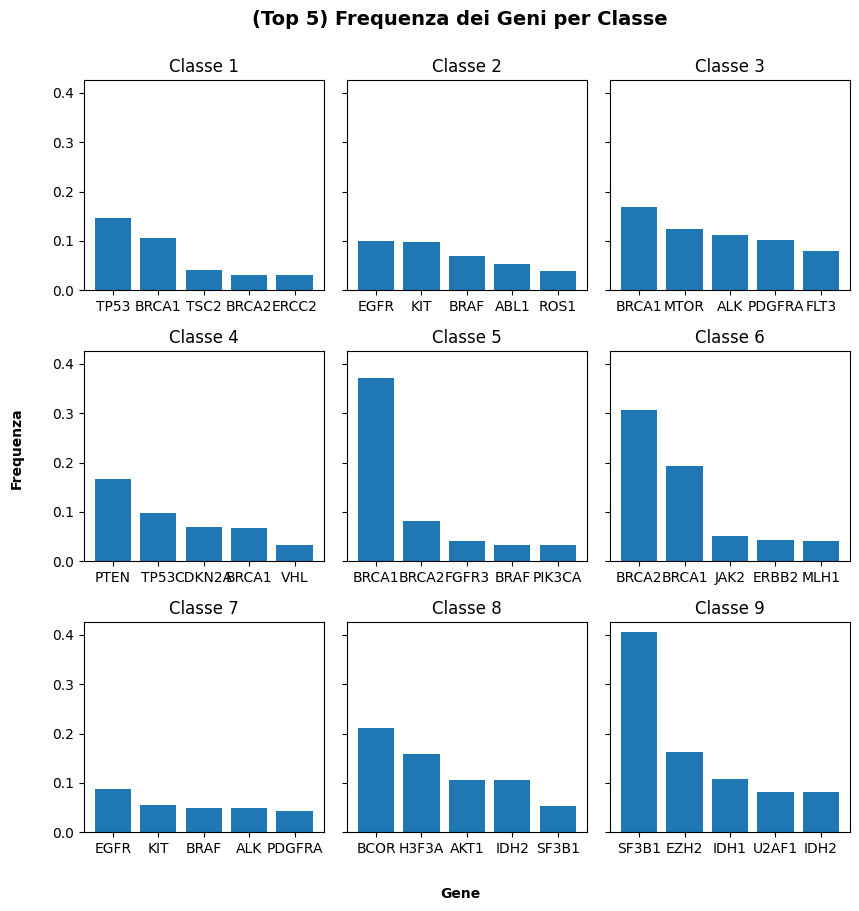

In [17]:
# Creazione dei sottotitoli per il grafico
fig, axes = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(9, 9))

# Normalizzazione dei conteggi per una migliore comparazione
def normalize_group(x):
    label, repetition = x.index, x
    t = sum(repetition)
    r = [n/t for n in repetition]
    return label, r

# Creazione dei grafici per ogni classe
for idx, g in enumerate(training_tot.groupby('Class')):
    label, val = normalize_group(g[1]["Gene"].value_counts())
    ax = axes.flat[idx]
    ax.bar(np.arange(5), val[:5], tick_label=label[:5]) 
    ax.set_title("Classe {}".format(g[0]))

# Etichette
fig.text(0.5, 0.97, '(Top 5) Frequenza dei Geni per Classe', ha='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0, 'Gene', ha='center', fontweight='bold')
fig.text(0, 0.5, 'Frequenza', va='center', rotation='vertical', fontweight='bold')

# Ottimizzazione del layout
fig.tight_layout(rect=[0.03, 0.03, 0.95, 0.95])


<h3> - VARIANTI</h3>

In [18]:
unique_variations = training_tot['Variation'].value_counts()

# Stampa del numero di Varianti uniche
print('Numero di Varianti Uniche:', unique_variations.shape[0])
print(' ')

# Stampa delle top 10 Varianti più frequenti senza "name" e "dtype"
print("Top 5 Varianti più frequenti:")
print(' ')
for variation, count in unique_variations.head(10).items():
    print(f'{variation}: {count}')

Numero di Varianti Uniche: 2993
 
Top 5 Varianti più frequenti:
 
Truncating Mutations: 92
Deletion: 74
Amplification: 70
Fusions: 34
Overexpression: 6
G12V: 4
Q61L: 3
E17K: 3
T58I: 3
Q61R: 3


In [19]:
# Conta i valori delle varianti e prendi solo le prime 20 più frequenti
variations_data = training_tot['Variation'].value_counts().head(20)

# Crea il grafico a barre con personalizzazioni
fig = px.bar(
    variations_data,
    title='Distribuzione delle 20 varianti più frequenti',
    labels={'index': 'Variante', 'value': 'Frequenza'}  # Modifica etichette degli assi
)

# Personalizzazione del titolo e dei font
fig.update_layout(
    title={
        'text': 'Distribuzione delle 20 varianti più frequenti',
        'y': 0.9,  # posizione verticale
        'x': 0.5,  # posizione orizzontale (centrale)
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Variante',  # Titolo dell'asse x
    yaxis_title='Frequenza',  # Titolo dell'asse y
    font=dict(
        family="Arial, sans-serif",
        size=14,
        color="black"
    ),
    showlegend=False  # Rimuove la legenda
)

# Mostra il grafico
fig.show()


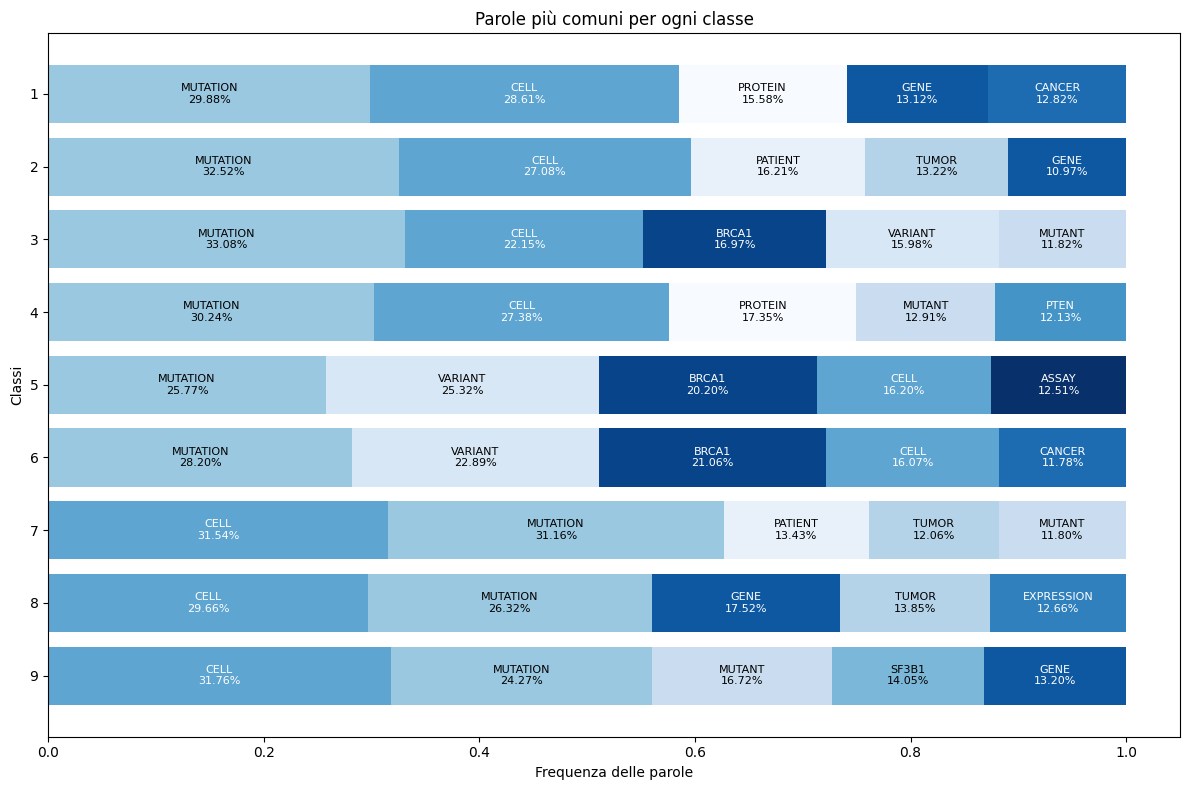

In [20]:
# Funzione per normalizzare la frequenza delle parole
def normalize_row(x):
    label, repetition = zip(*x)
    t = sum(repetition)
    r = [n/t for n in repetition]
    return list(zip(label, r))

# applichiamo il process_corpus al nostro dataset completo 
processed_corpus = process_corpus(training_tot, 'text', 'Class')

# Ottieni le 5 parole più frequenti per ogni classe
class_freq = processed_corpus.apply(lambda x: x.most_common(5))

# Converti il risultato in un DataFrame
class_freq_df = pd.DataFrame.from_records(class_freq.values.tolist(), index=class_freq.index, columns=[f'Top{i+1}' for i in range(5)])

# Applichiamo la normalizzazione riga per riga
class_freq = class_freq.apply(lambda x: normalize_row(x))

# Estraiamo tutte le etichette (parole)
all_labels = []
for row in class_freq.values:
    all_labels.extend([label for label, _ in row])
all_labels = list(set(all_labels))  # Rimuoviamo i duplicati

# Creiamo un dizionario di colori unici per ogni parola
unique_labels = set(all_labels)
cm = plt.get_cmap('Blues_r', len(all_labels))
colors = {k: cm(all_labels.index(k) / len(all_labels)) for k in all_labels}

# Creiamo la figura e l'asse per il grafico
fig, ax = plt.subplots(figsize=(12, 8))
offset = np.zeros(len(class_freq))

# Cicliamo su ogni parola (massimo 5 per classe)
for col in range(5):  # Supponiamo che ci siano 5 parole per ogni classe
    labels = [row[col][0] if col < len(row) else '' for row in class_freq.values]
    heights = [row[col][1] if col < len(row) else 0 for row in class_freq.values]
    
    # Disegniamo i grafici a barre orizzontali
    bars = ax.barh(range(len(class_freq)), heights, left=offset, color=[colors[l] if l else 'white' for l in labels])
    
    # Annotiamo le parole direttamente sulle barre
    for i, (label, height) in enumerate(zip(labels, heights)):
        if height > 0:
            x = offset[i] + height / 2
            y = i
            fc = 'k' if sum(colors[label][:3]) > 2 else 'w'  # Colore del testo in base al contrasto
            ax.text(x, y, f'{label.upper()}\n{height:.2%}', ha='center', va='center', color=fc, fontsize=8)
    
    offset += heights

# Impostiamo le etichette sull'asse delle y e invertiamo l'ordine
ax.set_yticks(np.arange(len(class_freq)))
ax.set_yticklabels(class_freq.index)
ax.invert_yaxis()

# Impostiamo titolo e etichette sugli assi
ax.set_title('Parole più comuni per ogni classe')
ax.set_xlabel('Frequenza delle parole')
ax.set_ylabel('Classi')

# Mostriamo il grafico con una disposizione più stretta
plt.tight_layout()
plt.show()

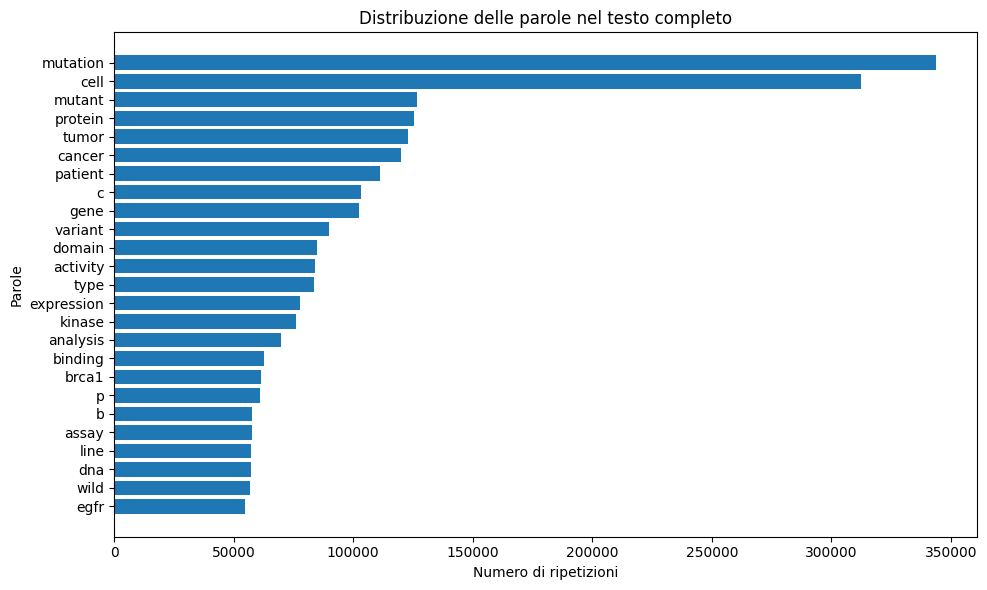

In [21]:
whole_text_freq = processed_corpus.sum()

# Creiamo la figura e l'asse per il grafico
fig, ax = plt.subplots(figsize=(10, 6))

# Estraiamo le 25 parole più comuni e le loro frequenze
label, repetition = zip(*whole_text_freq.most_common(25))

# Creiamo un grafico a barre orizzontali
ax.barh(range(len(label)), repetition, align='center')

# Impostiamo le etichette sull'asse delle y con i nomi delle parole
ax.set_yticks(np.arange(len(label)))
ax.set_yticklabels(label)
ax.invert_yaxis()  # Invertiamo l'ordine delle parole per avere la più frequente in alto

# Impostiamo titolo e etichette sugli assi
ax.set_title('Distribuzione delle parole nel testo completo')
ax.set_xlabel('Numero di ripetizioni')
ax.set_ylabel('Parole')

# Mostriamo il grafico con una disposizione più stretta
plt.tight_layout()
plt.show()


<h2> MODELLAZIONE</h2>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Dopo aver completato le operazioni di <b>Analisi Esplorativa dei Dati (EDA)</b> e di <b>Natural Language Processing (NLP)</b>, siamo pronti a procedere con la <b>modellazione</b>. Queste fasi preliminari ci hanno fornito le informazioni necessarie per scegliere i modelli più adatti e ottimizzare le loro performance.
</p>


<h3> SUDDIVISIONE DEL DATASET IN DATI DI TRAINING E DI TEST </h3>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
In questo codice, i testi vengono trasformati in vettori numerici utilizzando la tecnica <strong>TF-IDF</strong> (Term Frequency-Inverse Document Frequency), che valuta l'importanza delle parole nei documenti. Successivamente, i dati vengono suddivisi in <strong>training set</strong> e <strong>test set</strong>: il training set verrà utilizzato per addestrare il modello, mentre il test set servirà per valutarne le prestazioni. Questa suddivisione consente di verificare come il modello <strong>generalizza</strong> su dati mai visti prima.
</p>
<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Il parametro <strong>random_state=42</strong> viene utilizzato per garantire che la suddivisione dei dati sia sempre la stessa ogni volta che viene eseguito il codice. Questo rende i risultati riproducibili e facilita il confronto tra i diversi modelli utilizzati, poiché il campionamento casuale avviene nello stesso modo ogni volta.
</p>

In [22]:
# Creazione delle feature TF-IDF dai testi di addestramento
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(training_tot['text'])
y = training_tot['Class']

# Suddivisione del dataset di trainging in training e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


<h3> K - NEAREST NEIGHBORS: </h3>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Per usufruire al meglio del modello <b>KNN (K - Nearest Neighbors)</b>, è necessario stimare e analizzare il numero di <b>"vicini più prossimi"</b> ottimale per garantire una <b>migliore prestazione predittiva</b>. Questo può avvenire attraverso diversi tipi di analisi e vari metodi di valutazione. In questo caso, eseguiremo un confronto con la metrica <b>Log Loss</b>, poiché è una delle più adatte per problemi <b>multi-classe</b> come il nostro (9 classi), penalizzando maggiormente le previsioni <b>incerte</b> o <b>errate</b> ed essendo più sensibile agli errori.
<br><br>
Addestriamo il modello per un diverso numero di <b>vicini prossimi (5-1000)</b> e calcoliamo il Log Loss per ciascuno di essi:
</p>


In [23]:
# Lista dei vicini più prossimi da testare
num_neighbours = [5, 10, 15, 40, 50, 120, 150, 160, 170, 180, 200, 400, 500, 1000]
log_loss_values = []

# Ciclo per testare ciascun numero di vicini più prossimi
for n_neighbours in num_neighbours:
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbours)
    knn_model.fit(X_train, y_train)
    
    # Predizioni con probabilità
    y_pred_prob = knn_model.predict_proba(X_test)
    
    # Calcolo della log loss
    log_loss_value = log_loss(y_test, y_pred_prob)
    log_loss_values.append(log_loss_value)
    
    # Stampa dei risultati
    print(f'Per {n_neighbours} vicini più prossimi, la log loss è: {log_loss_value}')


Per 5 vicini più prossimi, la log loss è: 5.965381806565817
Per 10 vicini più prossimi, la log loss è: 3.8453140948109614
Per 15 vicini più prossimi, la log loss è: 2.9955989664817055
Per 40 vicini più prossimi, la log loss è: 1.9967910454942936
Per 50 vicini più prossimi, la log loss è: 1.791597743114363
Per 120 vicini più prossimi, la log loss è: 1.3609933920382886
Per 150 vicini più prossimi, la log loss è: 1.3881651797350842
Per 160 vicini più prossimi, la log loss è: 1.3969911264001824
Per 170 vicini più prossimi, la log loss è: 1.407881757455236
Per 180 vicini più prossimi, la log loss è: 1.4130660619049344
Per 200 vicini più prossimi, la log loss è: 1.4297458627189468
Per 400 vicini più prossimi, la log loss è: 1.5126756342415038
Per 500 vicini più prossimi, la log loss è: 1.5428802081409434
Per 1000 vicini più prossimi, la log loss è: 1.6527255602843747


<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Notiamo come, già da questa panoramica, nell'intorno tra i <b>120 e i 160 vicini più prossimi</b> si ottenga un <b>valore di Log Loss più basso</b>. Verifichiamo inoltre attraverso l'uso di un altro strumento, ovvero <b>"GridSearch"</b>, che esegue una <b>ricerca sistematica</b> sfruttando una <b>validazione incrociata</b> per valutare le prestazioni del modello su ciascun valore:
</p>


In [24]:
from sklearn.model_selection import GridSearchCV

# Definisci l'intervallo dei valori di n_neighbors da testare
param_grid = {'n_neighbors': [5, 10, 15, 20, 40, 80, 160, 200]}

# Inizializza il modello
knn = KNeighborsClassifier()

# Esegui una ricerca a griglia (grid search) con la validazione incrociata
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_log_loss') # o 'log_loss', 'f1', ecc.
grid_search.fit(X_train, y_train)

# Stampa solo il numero ottimale di vicini
print("Miglior numero di vicini:", grid_search.best_params_['n_neighbors'])


Miglior numero di vicini: 160


In [25]:
# Creazione di un dizionario con i risultati
risultati = {'Numero Vicini': num_neighbours, 'Log Loss': log_loss_values}

# Conversione del dizionario in un DataFrame
risultati_df = pd.DataFrame(risultati)

# Ordinamento del DataFrame per numero di vicini in ordine decrescente
risultati_df.sort_values(by='Numero Vicini', ascending=False, inplace=True)

# Creazione di un grafico a linee per visualizzare i risultati
figura = px.line(risultati_df, x="Numero Vicini", y="Log Loss", title='Numero Vicini vs Log Loss')
figura.show()


<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Avendo avuto la conferma anche da questa <b>ulteriore analisi</b>, prendiamo in considerazione <b>160</b> come numero di <b>vicini più prossimi</b> da impostare nel modello. Procediamo quindi con l'<b>addestramento</b> per ottenere una panoramica, questa volta attraverso una <b>matrice di confusione</b>, che mostri l'<b>accuratezza</b> nella previsione delle classi.
</p>


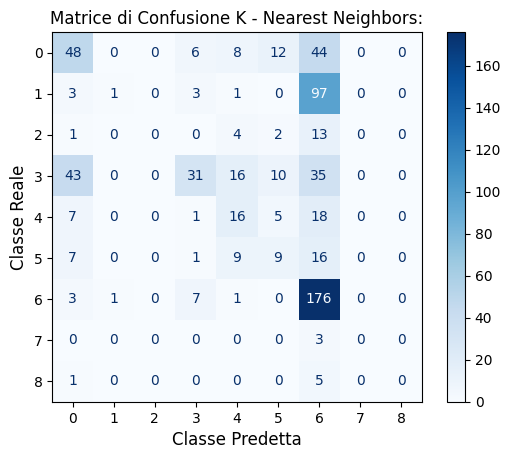

In [26]:
# Creazione e addestramento del modello con il miglior numero di vicini
modelKNN = KNeighborsClassifier(n_neighbors=160)
modelKNN.fit(X_train, y_train)

# Predizione sul set di test
y_pred = modelKNN.predict(X_test)

# Visualizzazione della matrice di confusione con traduzione delle etichette
matrice_confusione = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))

# Traccia la matrice
matrice_confusione.plot(cmap='Blues')

# Modifica del titolo della matrice di confusione
plt.title('Matrice di Confusione K - Nearest Neighbors:', fontsize=12)

# Modifica delle etichette degli assi
plt.xlabel('Classe Predetta', fontsize=12)
plt.ylabel('Classe Reale', fontsize=12)

# Mostra il grafico
plt.show()


<h3> RANDOM FOREST CLASSIFIER: </h3>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Come per il <b>modello precedente</b>, anche in questo caso, e nei prossimi, sfrutteremo il confronto con la metrica <b>Log Loss</b> per scegliere i migliori parametri per impostare i modelli di <b>Machine Learning</b>. In questo caso si tratta di definire il <b>numero di alberi decisionali</b> da utilizzare, insieme alla <b>giusta profondità</b>, per ottenere previsioni il più corrette possibile. <br>
Vediamo le due diverse analisi:
</p>


In [27]:
# Definire i valori da testare per n_estimators (alberi decisonali) da usare nel modello
n_estimators = [5, 50, 100, 200, 500, 1000]
log_loss_values = []

# Ciclo per testare ciascun valore di n_estimators
for n in n_estimators:
    # Inizializzare il modello Random Forest con il numero corrente di stimatori e una profondità massima di 9
    model = RandomForestClassifier(n_estimators=n, max_depth=9)
    
    # Addestrare il modello sui dati di addestramento
    model.fit(X_train, y_train)
    
    # Effettuare predizioni probabilistiche sul set di test
    predictions = model.predict_proba(X_test)
    
    # Calcolare il log loss
    log_loss_value = log_loss(y_test, predictions)
    
    # Memorizzare il valore di log loss nella lista
    log_loss_values.append(log_loss_value)
    
    # Stampare il numero di stimatori e il log loss corrispondente
    print(f'Per {n} alberi decisionali, il log loss è: {log_loss_value}')


Per 5 alberi decisionali, il log loss è: 1.3496573938348952
Per 50 alberi decisionali, il log loss è: 1.289666158671173
Per 100 alberi decisionali, il log loss è: 1.284717288557853
Per 200 alberi decisionali, il log loss è: 1.285475592646701
Per 500 alberi decisionali, il log loss è: 1.2800444224871035
Per 1000 alberi decisionali, il log loss è: 1.2809916935172274


In [28]:
# Definire l'intervallo dei valori di n_estimators da testare
param_grid = {'n_estimators': [50, 100, 200, 300]}

# Inizializzare il modello Random Forest
rf_model = RandomForestClassifier(max_depth=9)

# Eseguire una ricerca a griglia con validazione incrociata
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_log_loss')
grid_search.fit(X_train, y_train)

# Stampare il miglior valore di n_estimators
print('Miglior numero di Alberi:', grid_search.best_params_['n_estimators'])

Miglior numero di Alberi: 200


In [29]:
# Creare un dizionario con i valori di n_estimators (alberi) e log loss
results_dict = {'Numero Alberi': n_estimators, 'Log_Loss': log_loss_values}

# Creare un DataFrame da Pandas utilizzando il dizionario
model_df = pd.DataFrame(results_dict)

# Ordinare il DataFrame in base a N_estimators in ordine decrescente
model_df.sort_values(by='Numero Alberi', ascending=False, inplace=True)

# Creare un grafico a linee per visualizzare N_estimators rispetto a Log Loss
fig = px.line(model_df, x='Numero Alberi', y='Log_Loss', title='Numero Alberi vs Log Loss')

# Visualizzare il grafico
fig.show()


<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
L'analisi con il <b>Grid Search</b> consiglia <b>100</b> come numero di <b>estimators</b> (alberi decisionali) che il modello <b>Random Forest</b> deve utilizzare per essere più accurato nella predizione. Proviamo:
</p>


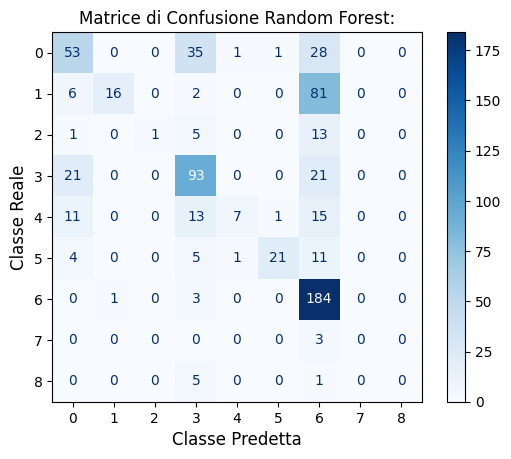

In [30]:
# Inizializzare il modello Random Forest con il miglior numero di stimatori e una profondità massima di 9
modelForest = RandomForestClassifier(n_estimators=100, max_depth=9)

# Addestrare il modello sui dati di addestramento
modelForest.fit(X_train, y_train)

# Effettuare predizioni sul set di test
predictions = modelForest.predict(X_test)

# Creare una matrice di confusione
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))

#traccia la matrice
confusion_matrix_display.plot(cmap='Blues')

# Modifica del titolo della matrice di confusione
plt.title('Matrice di Confusione Random Forest:', fontsize=12)

# Modifica delle etichette degli assi
plt.xlabel('Classe Predetta', fontsize=12)
plt.ylabel('Classe Reale', fontsize=12)

# Visualizzare la matrice di confusione
plt.show()


<h3> CLASSIFICATORE MULTINOMIALE NAIVE BAYES </h3>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Il <b>Classificatore Multinomiale di Bayes</b> è un algoritmo di apprendimento automatico efficace per la <b>classificazione di dati</b> in categorie multiple, particolarmente adatto per problemi di <b>classificazione di testo</b>. 
<br><br>
Analizziamo i diversi valori di <b>Alpha</b> che offrono una <b>precisione migliore</b> nella predizione:
</p>


In [31]:
# Definire l'intervallo dei valori di alpha da testare
alpha_values = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
log_loss_values = []

# Ciclo per testare ciascun valore di alpha
for alpha in alpha_values:
    # Inizializzare il modello MultinomialNB con il valore corrente di alpha
    model = MultinomialNB(alpha=alpha)
    
    # Addestrare il modello sui dati di addestramento
    model.fit(X_train, y_train)
    
    # Effettuare predizioni sul set di test con probabilità
    predictions_prob = model.predict_proba(X_test)
    
    # Calcolare la log loss
    log_loss_value = log_loss(y_test, predictions_prob)
    
    # Aggiungere il valore della log loss alla lista
    log_loss_values.append(log_loss_value)
    
    # Stampare il valore di alpha e il corrispondente log loss
    print(f'Per alpha = {alpha}, la log loss è: {log_loss_value}')


Per alpha = 0.0001, la log loss è: 2.612705150300361
Per alpha = 0.001, la log loss è: 2.1395295260748743
Per alpha = 0.01, la log loss è: 1.78643276108441
Per alpha = 0.1, la log loss è: 2.3643751703908773
Per alpha = 1, la log loss è: 2.2408315615087218
Per alpha = 10, la log loss è: 1.6466401391904844
Per alpha = 100, la log loss è: 1.7445519722275953


In [32]:
# Definire l'intervallo dei valori di alpha da testare
param_grid = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}

# Inizializzare il modello MultinomialNB
model = MultinomialNB()

# Eseguire una ricerca a griglia con validazione incrociata per trovare il miglior alpha
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_log_loss', cv=5)
grid_search.fit(X_train, y_train)

# Stampare il miglior valore di alpha
print('Miglior valore di alpha:', grid_search.best_params_['alpha'])

Miglior valore di alpha: 10


In [33]:
# Creare un dizionario con i valori di alpha e log loss
data_dict = {'Valore di Alpha': alpha_values, 'Log_Loss': log_loss_values}

# Creare un DataFrame da un dizionario
model_df = pd.DataFrame(data_dict)

# Ordinare il DataFrame in base ai valori di Alpha in ordine decrescente
model_df.sort_values(by='Valore di Alpha', ascending=False, inplace=True)

# Creare un grafico a linee per visualizzare Alpha rispetto a Log Loss
fig = px.line(model_df, x='Valore di Alpha', y='Log_Loss', title='Valore di Alpha vs Log Loss')

# Mostrare il grafico
fig.show()


<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
In questo caso, entrambi i metodi consigliano l'uso di <b>10</b> come valore di <b>Alpha</b> per il <b>Classificatore Naive Bayes</b>. Proviamo:
</p>


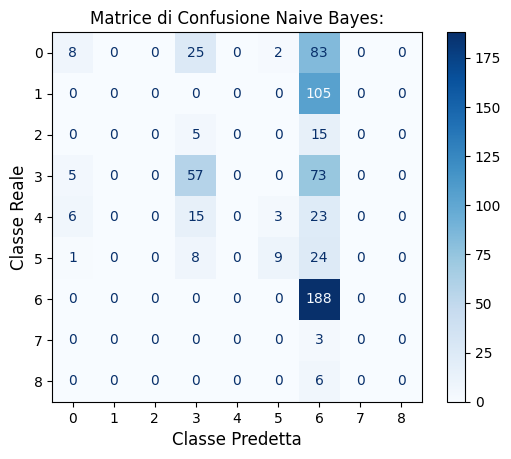

In [34]:
# Inizializzare il modello MultinomialNB con il miglior valore di alpha
modelBayes = MultinomialNB(alpha=10)

# Addestrare il modello sui dati di addestramento
modelBayes.fit(X_train, y_train)

# Effettuare predizioni sul set di test
predictions = modelBayes.predict(X_test)

# Creare una matrice di confusione
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix(y_test, predictions))

#traccia la matrice
confusion_matrix_display.plot(cmap='Blues')

# Modifica del titolo della matrice di confusione
plt.title('Matrice di Confusione Naive Bayes:', fontsize=12)

# Modifica delle etichette degli assi
plt.xlabel('Classe Predetta', fontsize=12)
plt.ylabel('Classe Reale', fontsize=12)

# Visualizzare la matrice di confusione
plt.show()


<h3> REGRESSIONE LOGISTICA</h3>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Anche per la <b>Regressione Logistica</b> analizziamo i diversi valori di <b>Alpha</b> che offrono una <b>precisione migliore</b> nella predizione:
</p>


In [35]:
# Definizione dei valori di alpha da testare
alpha_values = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
log_loss_results = []

# Ciclo per valutare ogni valore di alpha
for alpha in alpha_values:
    model = SGDClassifier(
        loss='log_loss', 
        alpha=alpha, 
        penalty='l2', 
        shuffle=True, 
        class_weight='balanced', 
        random_state=0
    )
    
    # Addestramento del modello
    model.fit(X_train, y_train)
    
    # Predizione sul set di test
    predictions = model.predict_proba(X_test)
    
    # Calcolo della log loss
    log_loss_value = log_loss(y_test, predictions)
    log_loss_results.append(log_loss_value)
    
    # Stampa dei risultati
    print(f'Con alpha = {alpha}, la log loss è {log_loss_value}')


Con alpha = 0.0001, la log loss è 1.054097425492624
Con alpha = 0.001, la log loss è 1.453288748576559
Con alpha = 0.01, la log loss è 1.9492278856944016
Con alpha = 0.1, la log loss è 2.152695048670675
Con alpha = 1, la log loss è 2.1922211916404626
Con alpha = 10, la log loss è 2.1966772246713884
Con alpha = 100, la log loss è 2.1971481770858285


In [36]:
# Definisci l'intervallo dei valori di alpha da testare
param_grid = {'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}

# Inizializza il modello SGDClassifier con i parametri fissi
sgd = SGDClassifier(
    loss='log_loss', 
    penalty='l2', 
    l1_ratio=0.5, 
    shuffle=True, 
    class_weight='balanced', 
    random_state=0
)

# Esegui una ricerca a griglia (GridSearchCV) con validazione incrociata
grid_search = GridSearchCV(sgd, param_grid, cv=5, scoring='neg_log_loss')  # scoring='neg_log_loss' per ottimizzare la log loss
grid_search.fit(X_train, y_train)

# Ottieni il miglior valore di alpha
print("Miglior valore di alpha:", grid_search.best_params_['alpha'])

Miglior valore di alpha: 0.0001


In [37]:
# Creazione di un dizionario con i valori di Alpha e Log Loss
results_dict = {'Valore di Alpha': alpha_values, 'Log_Loss': log_loss_results}

# Creazione del DataFrame a partire dal dizionario
model_df = pd.DataFrame(results_dict)

# Ordinamento dei dati per Alpha in ordine decrescente
model_df.sort_values(by='Valore di Alpha', ascending=False, inplace=True)

# Creazione del grafico a linee per visualizzare Alpha vs Log Loss
fig = px.line(
    model_df, 
    x='Valore di Alpha', 
    y='Log_Loss', 
    title='Valore di Alpha vs Log Loss'
)

# Aggiungere ticks personalizzati sull'asse X
fig.update_xaxes(
    dtick=5,  # Imposta il passo dei tick a 5
    tickmode='linear'  # Modalità tick lineare
)

# Visualizzazione del grafico
fig.show()


<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Usiamo <b>0.0001</b> come parametro per il modello:
</p>


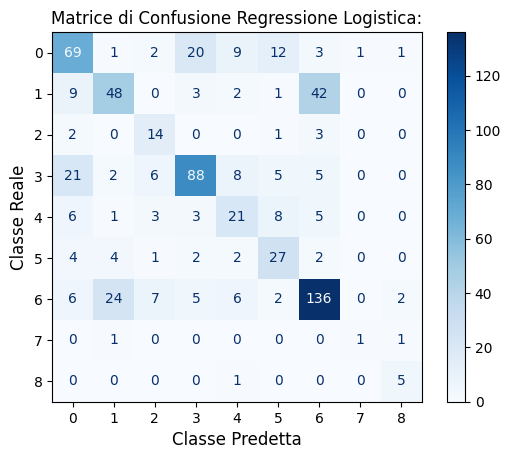

In [38]:
# Creazione e addestramento del modello con il miglior valore di alpha
modelRegression = SGDClassifier(
    loss='log_loss', 
    alpha=0.0001, 
    penalty='l2', 
    l1_ratio=0.5, 
    shuffle=True,
    class_weight='balanced', 
    random_state=0
)

# Addestramento del modello
modelRegression.fit(X_train, y_train)

# Predizione sul set di test
y_pred = modelRegression.predict(X_test)



# Visualizzazione della matrice di confusione
confusion_disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
confusion_disp.plot(cmap='Blues')

# Modifica del titolo della matrice di confusione
plt.title('Matrice di Confusione Regressione Logistica:', fontsize=12)

# Modifica delle etichette degli assi
plt.xlabel('Classe Predetta', fontsize=12)
plt.ylabel('Classe Reale', fontsize=12)

# Visualizzazione del grafico
plt.show()


<h2> PRIME CONCLUSIONI </h2>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Mettendo a confronto le matrici di confusione dei quattro modelli di machine learning testati, osserviamo che, scegliendo per ciascuno il miglior iperparametro in base alla metrica del log loss, la <strong>Regressione Logistica</strong> si distingue come il modello con le migliori prestazioni. In particolare, essa prevede la classe con una precisione maggiore, ottenendo un valore di <strong>Log loss </strong>pari a <strong>1.055</strong>. Lo stesso risultato si riscontra anche utilizzando l'accuratezza come metrica di valutazione: la Regressione Logistica raggiunge un <strong>Accuratezza</strong> di <strong>0.628</strong>, confermandosi il modello più performante nel complesso.
</p>


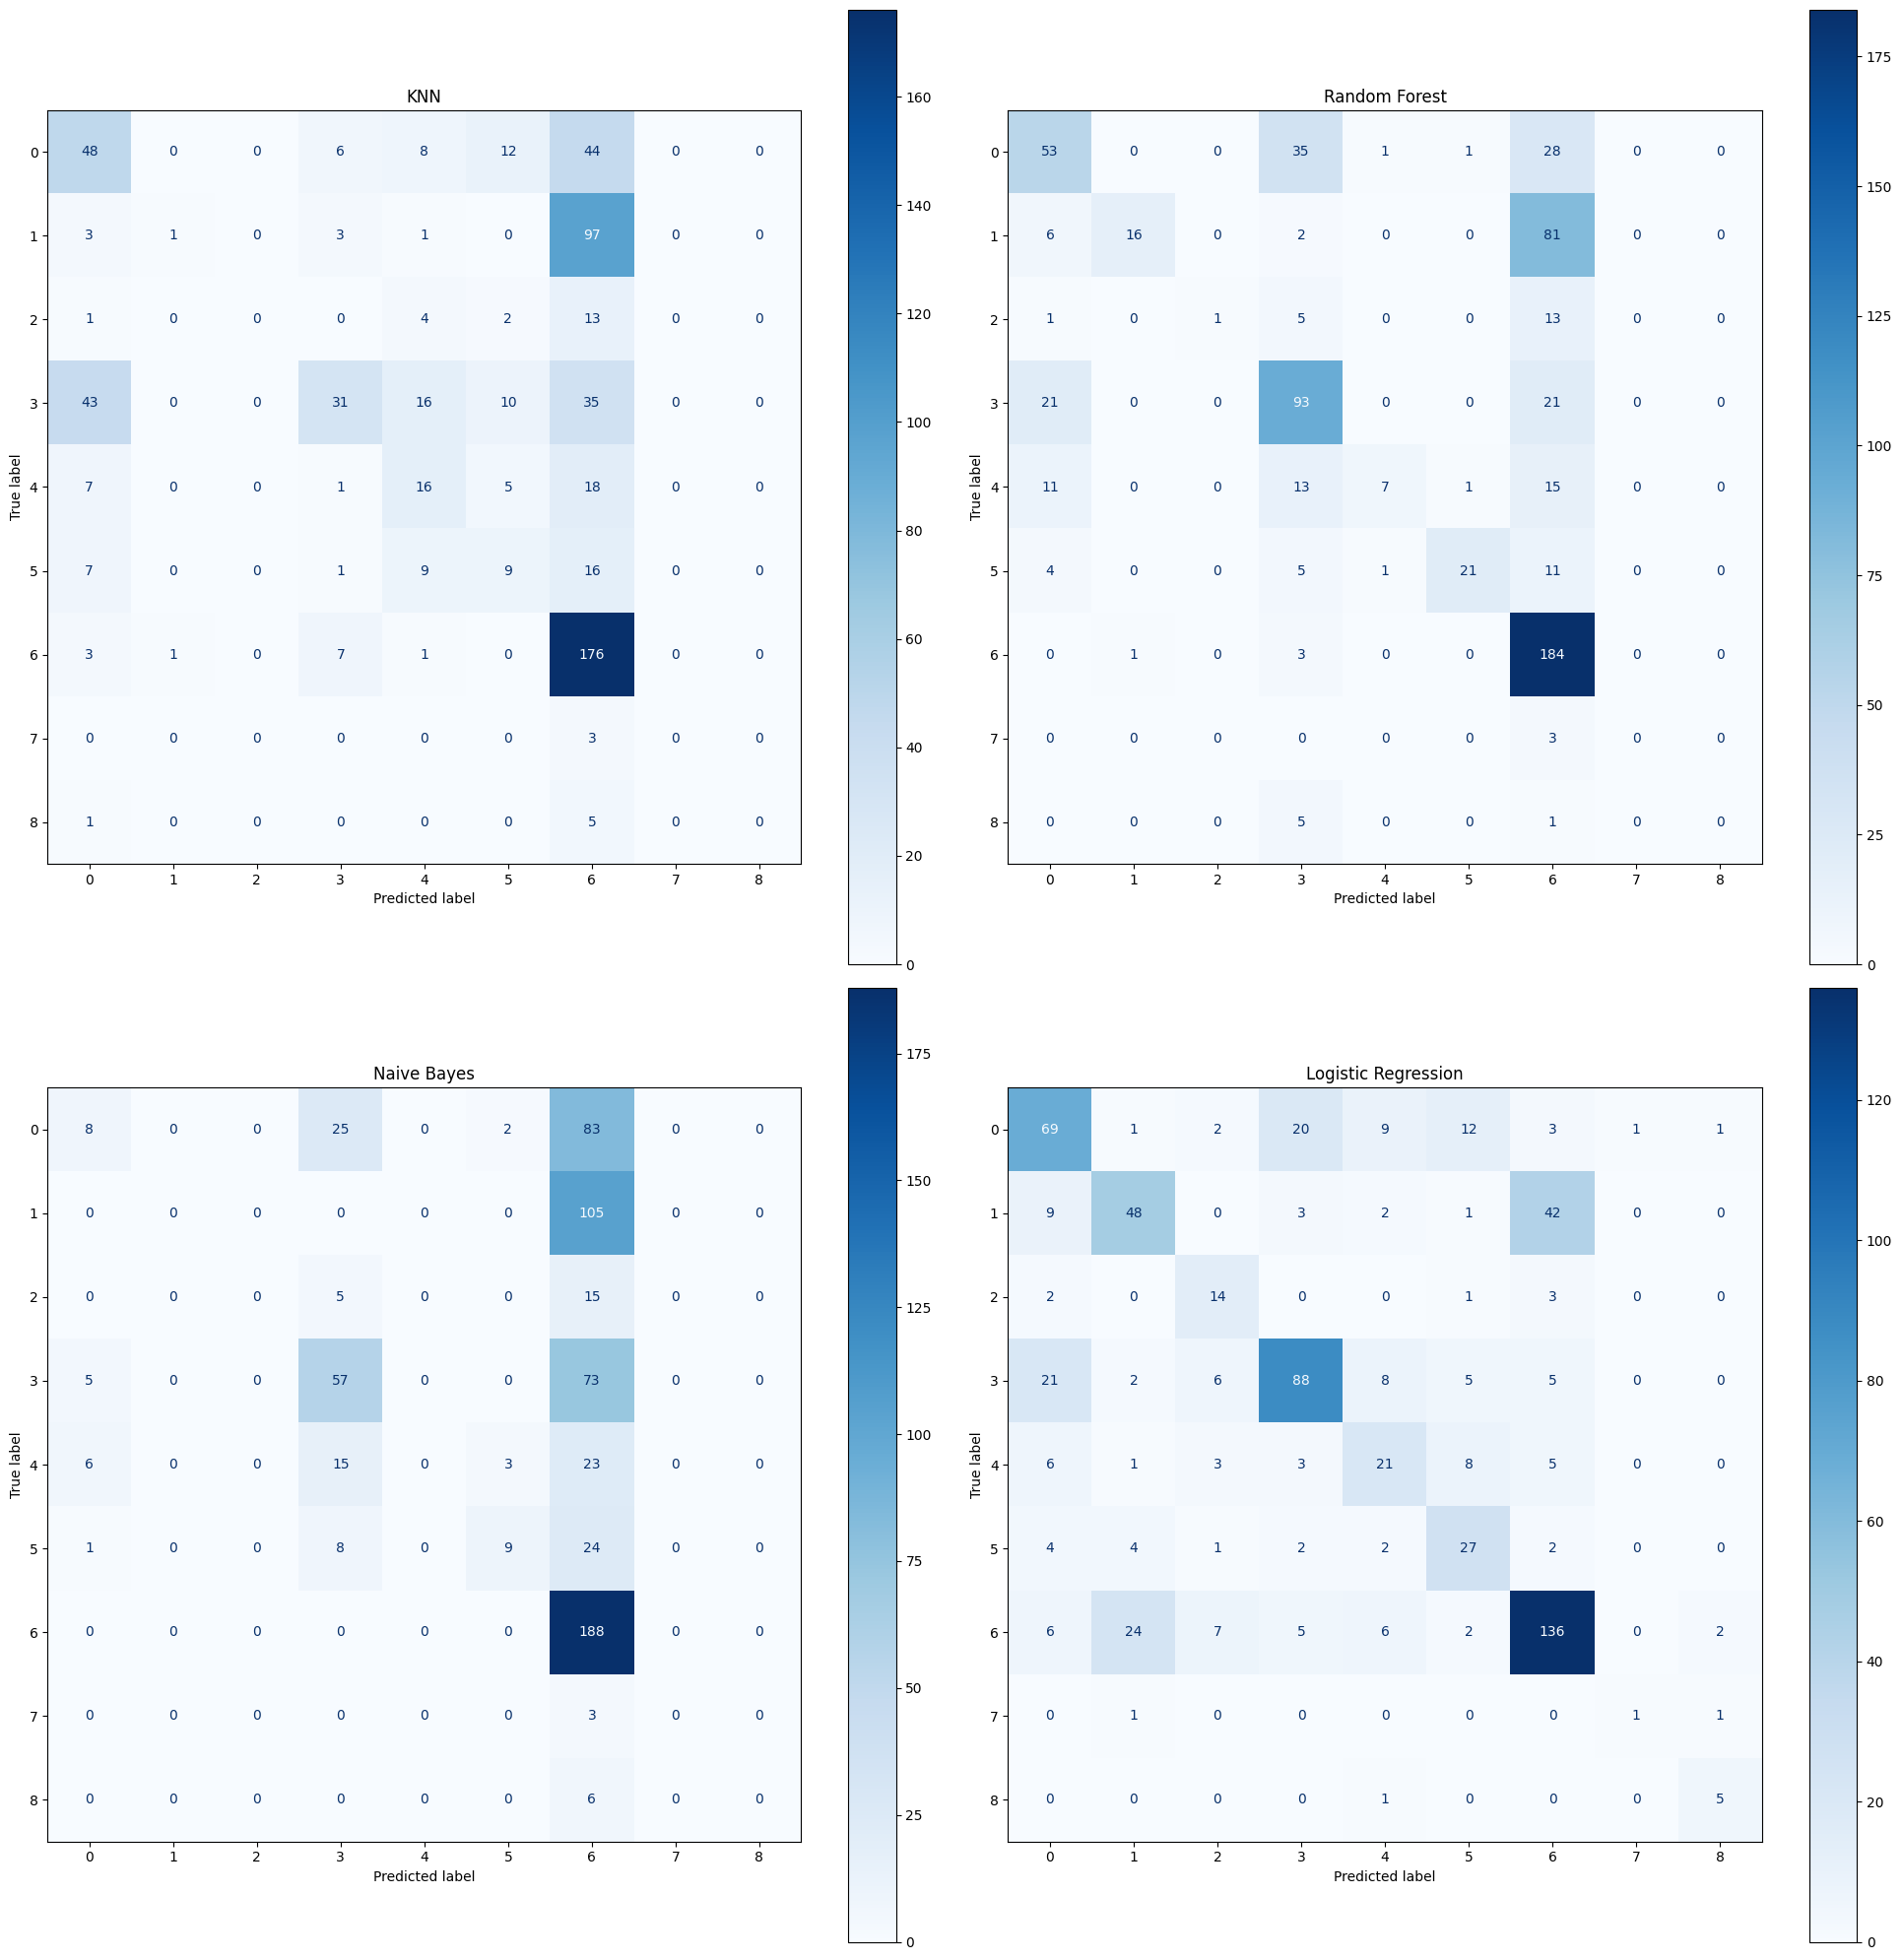

Accuratezza KNN: 0.42319277108433734
Accuratezza Random Forest: 0.5647590361445783
Accuratezza Naive Bayes: 0.39457831325301207
Accuratezza Logistic Regression: 0.6159638554216867



Log Loss KNN: 1.3969911264001824
Log Loss Random Forest: 1.284076162230871
Log Loss Naive Bayes: 1.6466401391904844
Log Loss Logistic Regression: 1.054097425492624


In [39]:
# Funzione per creare e visualizzare la matrice di confusione
def plot_confusion_matrix(model, X, y, ax, title):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax, cmap='Blues')
    ax.set_title(title)

# Creiamo una figura con 4 subplot, uno per ogni modello
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# KNN
plot_confusion_matrix(modelKNN, X_test, y_test, axs[0, 0], 'KNN')

# Random Forest
plot_confusion_matrix(modelForest, X_test, y_test, axs[0, 1], 'Random Forest')

# Naive Bayes
plot_confusion_matrix(modelBayes, X_test, y_test, axs[1, 0], 'Naive Bayes')

# Regressione Logistica
plot_confusion_matrix(modelRegression, X_test, y_test, axs[1, 1], 'Logistic Regression')

plt.tight_layout()
plt.show()

# Calcoliamo anche l'accuratezza per ogni modello
def calculate_accuracy(model, X, y):
    return model.score(X, y)

# Sequenze ANSI per il grassetto
bold_start = '\033[1m'
bold_end = '\033[0m'

print("Accuratezza KNN:", calculate_accuracy(modelKNN, X_test, y_test))
print("Accuratezza Random Forest:", calculate_accuracy(modelForest, X_test, y_test))
print("Accuratezza Naive Bayes:", calculate_accuracy(modelBayes, X_test, y_test))

# Stampa il valore della Regressione Logistica in grassetto
accuracy_logistic_regression = calculate_accuracy(modelRegression, X_test, y_test)
print("Accuratezza Logistic Regression:", bold_start + str(accuracy_logistic_regression) + bold_end)

# Funzione per calcolare il log loss
def calculate_log_loss(model, X, y):
    try:
        # Otteniamo le probabilità predette
        y_proba = model.predict_proba(X)
        return log_loss(y, y_proba)
    except AttributeError:
        # Se il modello non ha il metodo predict_proba
        return "Non disponibile per questo modello"

print("\n\n")

# Calcoliamo anche il log loss per ogni modello
print("Log Loss KNN:", calculate_log_loss(modelKNN, X_test, y_test))
print("Log Loss Random Forest:", calculate_log_loss(modelForest, X_test, y_test))
print("Log Loss Naive Bayes:", calculate_log_loss(modelBayes, X_test, y_test))

# Stampa il log loss della Regressione Logistica in grassetto
log_loss_logistic_regression = calculate_log_loss(modelRegression, X_test, y_test)
print("Log Loss Logistic Regression:", bold_start + str(log_loss_logistic_regression) + bold_end)
